<a href="https://colab.research.google.com/github/tgrappoport/2dmat/blob/master/10_TMDs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Electronic properties of Phosphorene

In this notebook we explore the electronic properties of phosphorene and its anisotropic characteristics. Phosphorene has a puckered lattice structure with four inequivalent phosphorus atoms in a unit cell. To model it, we use a simplified tight-binding Hamiltonian, presented in [A. N. Rudenko and M. I. Katsnelson
Phys. Rev. B 89, 201408(R) (2014).](https://doi.org/10.1103/PhysRevB.89.201408)

We begin by presenting the lattice, Brillouin zone and band structure where we can see the anisotropic characteristics the energy spectrum in $k_x$ and $k_y$. We then use quantum-kite to calculate the electronic longitudinal conductivities along x and y.  

We begin again with pybinding and kite installation

In [ ]:
%%capture --no-display
!pip install h5py==3.11.0
!pip install -i https://test.pypi.org/simple/ pybinding quantum-kite==0.0.4

and the libraries

In [ ]:
import numpy as np
from math import sqrt, pi
import pybinding as pb
import kite
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# seaborn setting
sns.set(style="ticks")
sns.set_style({"xtick.direction": "in", "ytick.direction": "in"})
sns.set_context("notebook", font_scale=1.2, rc={"lines.linewidth": 2.5})


There are many ways of modeling phosphorene. Here we use a [simplified tight-binding model](https://doi.org/10.1103/PhysRevB.89.201408) of 4 bands with increasing number of hoppings and define its pybinding lattice:

In [ ]:
def phosphorene_lattice(num_hoppings=4):
    """Monolayer phosphorene lattice using the four-band model

    Parameters
    ----------
    num_hoppings : int
        Number of hopping terms to consider: from t2 to t5.
    """
    a = 0.222  # nm
    ax = 0.438  # nm
    ay = 0.332  # nm
    theta = 96.79 * (pi / 180)
    phi = 103.69 * (pi / 180)

    lat = pb.Lattice(a1=[ax, 0], a2=[0, ay])

    h = a * np.sin(phi - pi / 2)
    s = 0.5 * ax - a * np.cos(theta / 2)
    lat.add_sublattices(('A', [-s/2,        -ay/2, h], 0),
                        ('B', [ s/2,        -ay/2, 0], 0),
                        ('C', [-s/2 + ax/2,     0, 0], 0),
                        ('D', [ s/2 + ax/2,     0, h], 0))

    lat.register_hopping_energies({'t1': -1.22, 't2': 3.665, 't3': -0.205,
                                   't4': -0.105, 't5': -0.055})

    if num_hoppings < 2:
        raise RuntimeError("t1 and t2 must be included")
    elif num_hoppings > 5:
        raise RuntimeError("t5 is the last one")

    if num_hoppings >= 2:
        lat.add_hoppings(([-1,  0], 'A', 'D', 't1'),
                         ([-1, -1], 'A', 'D', 't1'),
                         ([ 0,  0], 'B', 'C', 't1'),
                         ([ 0, -1], 'B', 'C', 't1'))
        lat.add_hoppings(([ 0,  0], 'A', 'B', 't2'),
                         ([ 0,  0], 'C', 'D', 't2'))
    if num_hoppings >= 3:
        lat.add_hoppings(([ 0,  0], 'A', 'D', 't3'),
                         ([ 0, -1], 'A', 'D', 't3'),
                         ([ 1,  1], 'C', 'B', 't3'),
                         ([ 1,  0], 'C', 'B', 't3'))
    if num_hoppings >= 4:
        lat.add_hoppings(([ 0,  0], 'A', 'C', 't4'),
                         ([ 0, -1], 'A', 'C', 't4'),
                         ([-1,  0], 'A', 'C', 't4'),
                         ([-1, -1], 'A', 'C', 't4'),
                         ([ 0,  0], 'B', 'D', 't4'),
                         ([ 0, -1], 'B', 'D', 't4'),
                         ([-1,  0], 'B', 'D', 't4'),
                         ([-1, -1], 'B', 'D', 't4'))
    if num_hoppings >= 5:
        lat.add_hoppings(([-1,  0], 'A', 'B', 't5'),
                         ([-1,  0], 'C', 'D', 't5'))

    lat.min_neighbors = 2
    return lat

We than define the lattice as phosphorene_lattice(), plot the lattice with its hoppings, how it looks like in an extended system, its Brillouin zone, which is a rectangle and the band structure.

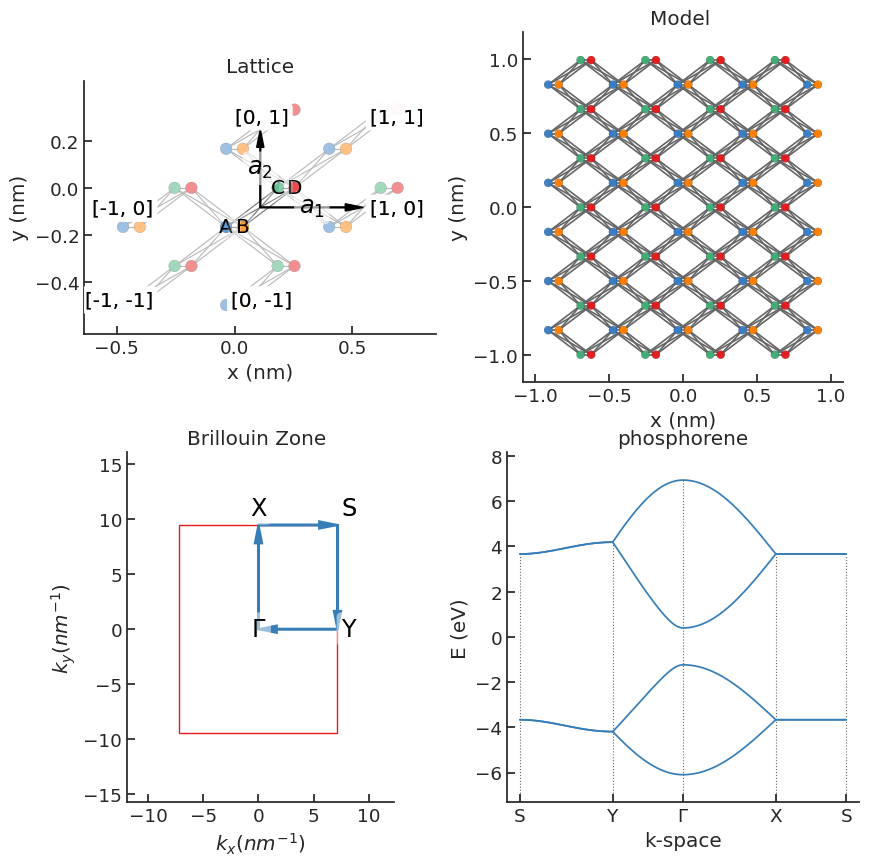

In [ ]:
lattice=phosphorene_lattice()
plot=plt.figure(figsize=(10., 10.))
plt.subplot(221, title="Lattice")
lattice.plot()
model = pb.Model(phosphorene_lattice(num_hoppings=4), pb.rectangle(2))
plt.subplot(222, title="Model ")
model.plot(hopping={'width': 2, 'cmap': 'auto'})
plt.subplot(223, title="Brillouin Zone ")
model.lattice.plot_brillouin_zone(decorate=False)

model = pb.Model(phosphorene_lattice(num_hoppings=4), pb.translational_symmetry())
solver = pb.solver.lapack(model)

ax = 0.438
ay = 0.332
kx = pi / ax
ky = pi / ay
bands = solver.calc_bands([kx, ky], [kx, 0], [0, 0], [0, ky], [kx, ky])
bands.plot_kpath(point_labels=["S", "Y", r"$\Gamma$", "X", "S"])
plt.subplot(224, title="phosphorene")

bands.plot(point_labels=["S", "Y", r"$\Gamma$", "X", "S"])
plt.show()


plt.show(plot)

From the plots above, we can see a few things: The Brillioun zone is a rectangle and in the selected path we move in the $k_x$ axis with the $\Gamma-Y$ part and in the $k_y$ with the $\Gamma-X$. At the top of the valence band and bottom of conduction band, the dispersion is linear if moving in the $k_x$ axis and quadratic if moving in the $k_y$ axis




Now let us try to see the consequences of this difference in the dispersion on the transport properties of phosphorene. For that, we use quantum kite and calculate the conductivity using Kubo-Greenwood formula and the [`singleshot` calculation](https://quantum-kite.com/api/kite/#calculation-singleshot_conductivity_dc).

We begin with the normal definitions used by kite:

Number of decomposition parts `[nx,ny]` in each direction of matrix:

In [ ]:
nx = ny = 2

Number of unit cells in each direction:

In [ ]:
lx = ly = 256

Boundary Mode:

In [ ]:
mode = "periodic"

Setting the configuration with a spectrum range given by [-10 eV, 10 eV] (one could give a better guess based on the band structure calculated above):

In [ ]:
configuration = kite.Configuration(
        divisions=[nx, ny],
        length=[lx, ly],
        boundaries=[mode, mode],
        is_complex=False,
        spectrum_range=[-10, 10],
        precision=1
    )


For the Kubo-Greenwood calculation of the conductivity $\sigma_{xx}(E_F)$ we define an energy grid of $E_F$ that will be used in the calculation as the `singleshot_conductivity_dc` is energy dependent



In [ ]:
num_points = 20
energy = np.linspace(0.0, 1.5, num_points)


Now we specify the calculation type, requiring the calculation of `singleshot_conductivity_dc`. Because of the anisotropy of the electronic properties of phosphorene, we will define two different calculations, one for xx and another for yy and run the two calculations.

In [ ]:

calculation_xx = kite.Calculation(configuration)

calculation_xx.singleshot_conductivity_dc(
        energy=energy,
        num_moments=256,
        num_random=2,
        num_disorder=1,
        direction='xx',
        eta=0.05
)
calculation_yy = kite.Calculation(configuration)

calculation_yy.singleshot_conductivity_dc(
        energy=energy,
        num_moments=256,
        num_random=2,
        num_disorder=1,
        direction='yy',
        eta=0.05
)


We can now configure the two *.h5 files at the same time

In [ ]:

    output_file_xx = "phxx-output.h5"
    kite.config_system(lattice, configuration, calculation_xx, filename=output_file_xx)
    output_file_yy = "phyy-output.h5"
    kite.config_system(lattice, configuration, calculation_yy, filename=output_file_yy)

##############################################################################
#                        KITE | Release  1.1                                 #
#                        Kite home: quantum-kite.com                         #
#                                                                            #
#                        Copyright 2022, KITE                                #
##############################################################################

##############################################################################

SCALING:


Manual scaling is chosen. 


##############################################################################

BOUNDARY CONDITIONS:


Boundary conditions along the lattice vectors are set to:
 
a1: Periodic     a2: Periodic 


##############################################################################

DECOMPOSITION:


Chosen number of decomposition parts is: [2, 2] .
INFO: this product will correspond to the total number of thre

In [ ]:
kite.execute.kitex(output_file_xx);
kite.execute.kitex(output_file_yy);



<HDF5 dataset "IS_COMPLEX": shape (), type "<u4">
<HDF5 dataset "IS_COMPLEX": shape (), type "<u4">


Different from other calculations, we do not use kite-tools to extract the data of the singleshot conductivity. In that case, we use the script below to extract the data directly from the h5 file:

open the HDF5-files and read the data

In [ ]:
import h5py as hdf
file = hdf.File(output_file_xx, 'r+')
data_xx = np.array(file['Calculation/singleshot_conductivity_dc/SingleShot'], dtype=np.float64)
file.close()

file = hdf.File(output_file_yy, 'r+')
data_yy = np.array(file['Calculation/singleshot_conductivity_dc/SingleShot'], dtype=np.float64)
file.close()

    # export the files
filename=output_file_xx
output_xx = (filename[:-3] if filename[-3:] == ".h5" else filename) + ".dat"
data2 = np.array([data_xx[:, 0], data_xx[:, -1]]).transpose()
np.savetxt(output_xx, data2)
filename=output_file_yy
output_yy = (filename[:-3] if filename[-3:] == ".h5" else filename) + ".dat"
data2 = np.array([data_yy[:, 0], data_yy[:, -1]]).transpose()
np.savetxt(output_yy, data2)


We can now plot the conductivities


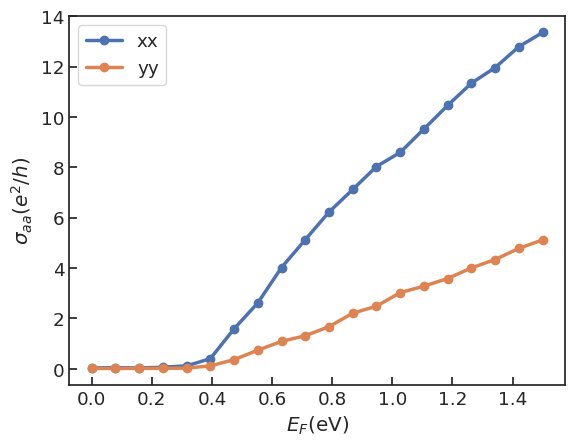

In [ ]:
condxx=np.loadtxt(output_xx,dtype=float)
condyy=np.loadtxt(output_yy,dtype=float)
plt.plot(condxx[:,0],condxx[:,1],marker="o",label="xx")
plt.plot(condyy[:,0],condyy[:,1],marker="o",label="yy")
plt.xlabel("$E_F$(eV)")
plt.ylabel("$\sigma_{aa}$($e^2/h$)")
plt.legend()
plt.show()
